In [31]:
%load_ext autoreload
%autoreload 2
import numpy as np
from DE_library import simulate_ODE, simulate_phase_portrait
import matplotlib.pyplot as plt

import sys
from MARBLE import utils, geometry, net, plotting

rng = np.random.RandomState(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Bogdanov-Takens system http://www.scholarpedia.org/article/Bogdanov-Takens_bifurcation

# For initial conditions, sample the $[-1,1]^2$ rectangle uniformly

In [32]:
t0, t1, dt = 0, 1, 0.2
t = np.arange(t0, t1, dt)
n = 100

eps=0.01
X0_range = [geometry.sample_2d(n, [[-3,-3],[3,3]], 'random') for i in range(4)]
for i, X0 in enumerate(X0_range):
    X0_range[i][np.abs(X0) < eps]=eps

# Display state spaces under four different parameter conditions

In [33]:
def simulate_system(mu, X0_range):
    pos, vel = simulate_phase_portrait('vanderpol', t, X0_range, par = {'mu': mu})
    return pos, vel

def plot_phase_portrait(pos, vel, ax):

    for p, v in zip(pos, vel):
        ax = plotting.trajectories(p, v, ax=ax, style='>', lw=1, arrowhead=.03, axis=False, alpha=None)
    ax.axis('square')
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/matplotlib/quiver.py:651: RuntimeWarning: overflow encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))


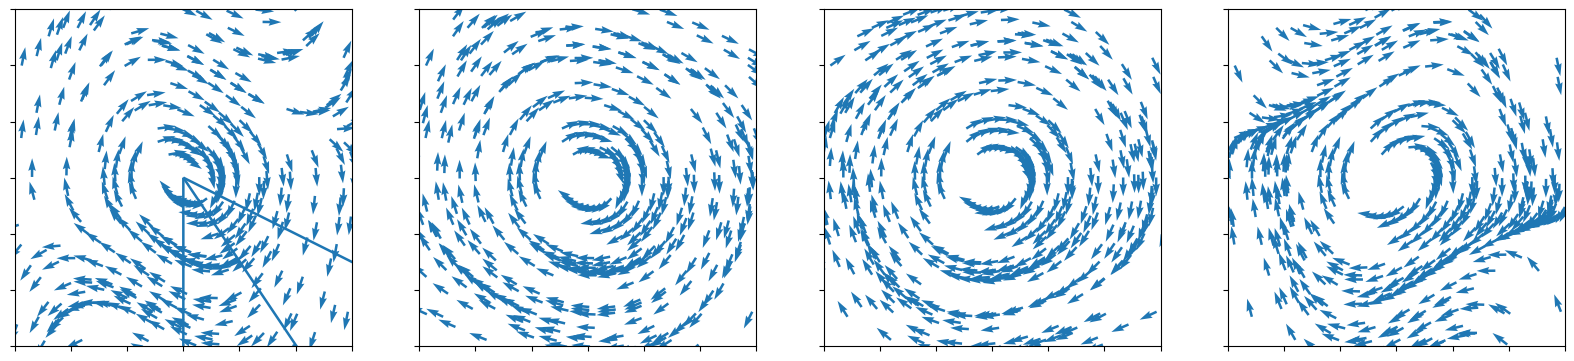

In [34]:
fig, ax = plt.subplots(1,4, figsize=(20,5))
    
pos, vel = simulate_system(-0.5, X0_range[0])
plot_phase_portrait(pos, vel, ax[0])
pos, vel = simulate_system(-0.1, X0_range[1])
plot_phase_portrait(pos, vel, ax[1])
pos, vel = simulate_system(0.1, X0_range[2])
plot_phase_portrait(pos, vel, ax[2])
pos, vel = simulate_system(0.5, X0_range[3])
plot_phase_portrait(pos, vel, ax[3])

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [35]:
#beta1 = np.hstack((np.linspace(-0.5,-0.2,5),np.linspace(0.2,0.5,5)))
beta1 = np.hstack((np.linspace(-0.5,0.5,10)))

pos, vel = [], []
for b1 in beta1:
    X0_range = geometry.sample_2d(n, [[-3,-3],[3,3]], 'random')
    p, v = simulate_system(b1, X0_range)
    p, v = np.vstack(p), np.vstack(v)
    vel_mag = np.linalg.norm(v, axis=1)
    
    ind = np.where((abs(p)<3).any(1) & (abs(vel_mag)<(vel_mag.mean() + vel_mag.std())))[0]
    v = v[ind,:]
    p = p[ind,:]
    
    pos.append(p)
    vel.append(v)

In [36]:
pos_subsample = pos
vel_subsample = vel
#ind = rng.permutation(len(beta1))
#pos_subsampl = [pos_subsample[i] for i in ind]
#vel_subsample = [vel_subsample[i] for i in ind]

# Subsample phase portrait

In [30]:
pos_subsample, vel_subsample = [], []
for i, (p,v) in enumerate(zip(pos,vel)):
    ind, _ = geometry.furthest_point_sampling(p, stop_crit=0.01)
    pos_subsample.append(p[ind])
    vel_subsample.append(v[ind])

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by check_pairwise_arrays.

Compare phase portraits before and after subsampling

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/matplotlib/quiver.py:651: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))


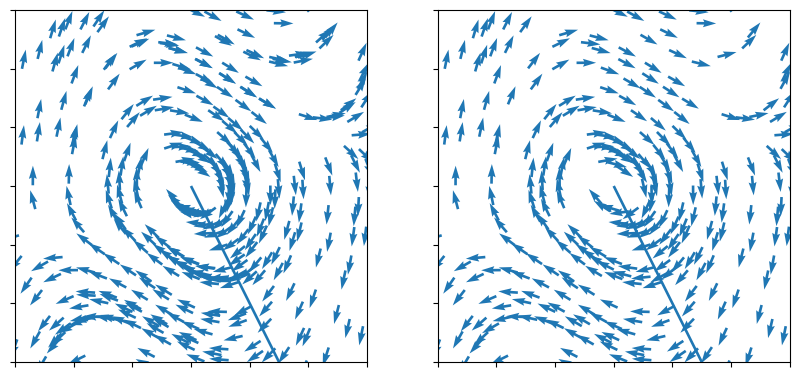

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

i=0
j=-1
#plot_phase_portrait([pos[j]], [vel[j]], ax[1])
plot_phase_portrait([pos[i]], [vel[i]], ax[0])
plot_phase_portrait([pos_subsample[i]], [vel_subsample[i]], ax[1])

# Train network

In [9]:
k=10

data = utils.construct_dataset(pos_subsample, features=vel_subsample, graph_type='cknn', k=k)

In [22]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

par = {'batch_size': 256, #batch size
       'epochs': 20, #optimisation epochs
       'order': 2, #order of derivatives
       'depth': 0, #number of hops in neighbourhood
       'n_lin_layers': 2,
       'hidden_channels': 16, #number of internal dimensions in MLP
       'out_channels': 4,
       'diffusion': False,
       'inner_product_features': True,
       'vector' : False
      }

model = net(data, **par)
model.run_training(data)

---- Settings: 

batch_size : 256
epochs : 20
order : 2
depth : 0
n_lin_layers : 2
hidden_channels : 16
out_channels : 4
diffusion : False
inner_product_features : True
vector : False
lr : 0.01
pretrained : True
frac_geodesic_nb : 2.0
var_explained : 0.9
dropout : 0.0
bias : False
batch_norm : batch_norm
seed : 0
signal_dim : 2
emb_dim : 2
n_geodesic_nb : 20
dim_embedding : 2

---- Number of features to pass to the MLP:  7
---- Total number of parameters:  488
---- Treating features as scalar channels.

---- Pretraining encoder ... 

Epoch: 1, reconstruction loss: 575.2412
Epoch: 2, reconstruction loss: 415.3962
Epoch: 3, reconstruction loss: 302.5001
Epoch: 4, reconstruction loss: 137.4679
Epoch: 5, reconstruction loss: 113.8901
Epoch: 6, reconstruction loss: 75.2161
Epoch: 7, reconstruction loss: 81.4104
Epoch: 8, reconstruction loss: 80.2623
Epoch: 9, reconstruction loss: 86.1349
Epoch: 10, reconstruction loss: 54.9214
Epoch: 11, reconstruction loss: 83.2265
Epoch: 12, reconstructio

# Create embeddings and cluster

In [23]:
n_clusters = 30
data = model.evaluate(data)

# Visualise embedding

Performed UMAP embedding on embedded results.


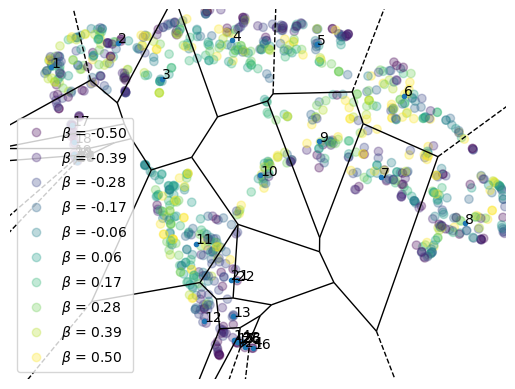

In [24]:
tsne_emb, clusters, dist = geometry.cluster_embedding(data, n_clusters=n_clusters, embed_typ='umap')
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]
plotting.embedding(tsne_emb, data.y.numpy(), clusters, titles=titles)

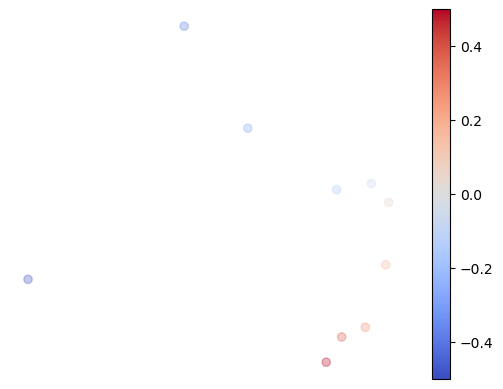

In [26]:
#dist = geometry.compute_distribution_distances(data)
emb_MDS = geometry.embed(dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS, beta1)

In [ ]:
plt.imshow(dist)